In [1]:
from torchvision.datasets import voc
import numpy as np
import os
import torch
import clip
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import copy
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
import sys
sys.path.insert(0, '../')
import utils as ut
import scipy.io
from sklearn.metrics import accuracy_score
from scipy.special import softmax

In [2]:
device = "cuda:0" #if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [3]:
dataset_orig = voc.VOCDetection("../../VOC", image_set='test', year = '2007', download=True)

Using downloaded and verified file: ../../VOC/VOCtest_06-Nov-2007.tar
Extracting ../../VOC/VOCtest_06-Nov-2007.tar to ../../VOC


In [4]:
len(dataset_orig)

4952

In [5]:
class VOCDataset(Dataset):
    """VOC Dataset ."""

    def __init__(self, root_dir, transform):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
       
        self.dataset = voc.VOCDetection(self.root_dir, image_set='test', year = '2007', transform=transform, download=True)
        
        self.classes = np.asarray(['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car',
           'motorbike', 'train', 'bottle', 'chair', 'dining table', 'potted plant', 'sofa', 'tv/monitor'])

            
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        objects = self.dataset[idx][1]['annotation']['object']
        labels = np.zeros(20)
        for ob in objects:
            idx = np.where(self.classes == ob['name'])[0]
#             print(ob['name'], idx)
            labels[idx] = 1
        
        return image, labels

In [6]:
dataset = VOCDataset("../../VOC", preprocess)

Using downloaded and verified file: ../../VOC/VOCtest_06-Nov-2007.tar
Extracting ../../VOC/VOCtest_06-Nov-2007.tar to ../../VOC


['person' 'dog'] 4952


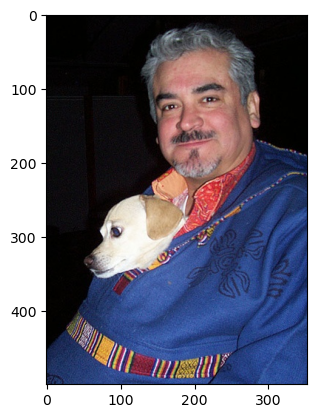

In [7]:
i =0
lb = dataset.classes[np.where(dataset[i][1])[0]]
print(lb, len(dataset))
plt.imshow(dataset_orig[i][0])

In [8]:
def get_features_voc(dataset, model):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            
            features = model.encode_image(images.to(device))
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features), torch.cat(all_labels).cpu().numpy()

In [9]:
features, labels = get_features_voc(dataset, model)
features /= features.norm(dim=-1, keepdim=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:43<00:00,  2.07s/it]


In [10]:
def check_acc_mult_label(predictions, labels):
    labels_gt = []
    for lb in labels:
        labels_gt.append(np.where(lb)[0])

    acc = 0
    t_num = 0
    for p, l in zip(predictions, labels_gt):
        
            
        if len(l) == 0:
#             print(l)
            continue
        elif p in l:
            acc +=1
#         if t_num == 0:
#             print("acc: ", acc, l, p)
        t_num+=1 
    return acc / t_num #len(predictions)

In [11]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {word.lower()}.") for word in dataset.classes]).to(device)
# text_inputs = torch.cat([clip.tokenize(f"a photo of a {word[0].strip()}.") for word in mat['class_names'][0]]).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * features @ text_features.T).softmax(dim=-1).cpu().numpy().astype(np.float64)
    predictions = np.argmax(similarity,axis=1)
    print(f'{check_acc_mult_label(predictions, labels)*100:.1f}')
#     f'{accuracy_score(predictions, labels)*100:.1f}'
#     print(accuracy_score(predictions, labels_gt)) mix of multiclass and unknown targets 

83.8


In [12]:
projection_GT,projection_inferred, MI_GT, MI_inferred, train_features, train_labels = ut.calculate_projections_ff(model, preprocess, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [03:38<00:00,  3.97it/s]


Error of predicting gender train = 0.06
 unique attr 7
Error of predicting race train = 0.37


In [13]:
print("********** Fair PCA GT ***************")
for attr in ['gender', 'race']:
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {word.lower()}.") for word in dataset.classes]).to(device)
    #text_inputs = torch.cat([clip.tokenize(f"a photo of a {word[0].strip()}.") for word in mat['class_names'][0]]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        projection_train = projection_GT[attr]
        all_features_val_transf = projection_train.just_transform(features.cpu().numpy().astype(np.float64))
        text_features_pca = projection_train.just_transform(text_features.cpu().numpy().astype(np.float64))
        similarity = softmax(100.0 * np.matmul(all_features_val_transf, np.transpose(text_features_pca)),axis=1)
        predictions = np.argmax(similarity,axis=1)
    #     print(np.around(np.mean(predictions == labels),2))
        print(f'{check_acc_mult_label(predictions, labels)*100:.1f}')


********** Fair PCA GT ***************
83.7
84.5


In [14]:
print("********** Fair PCA INF ***************")
for attr in ['gender', 'race']:
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {word.lower()}.") for word in dataset.classes]).to(device)
    #text_inputs = torch.cat([clip.tokenize(f"a photo of a {word[0].strip()}.") for word in mat['class_names'][0]]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        projection_train = projection_inferred[attr]
        all_features_val_transf = projection_train.just_transform(features.cpu().numpy().astype(np.float64))
        text_features_pca = projection_train.just_transform(text_features.cpu().numpy().astype(np.float64))
        similarity = softmax(100.0 * np.matmul(all_features_val_transf, np.transpose(text_features_pca)),axis=1)
        predictions = np.argmax(similarity,axis=1)
    #     print(np.around(np.mean(predictions == labels),2))
        print(f'{check_acc_mult_label(predictions, labels)*100:.1f}')

********** Fair PCA INF ***************
83.7
84.6


In [15]:
print("********** MI GT ***************")

for attr in ['gender', 'race']:
    print(attr)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {word.lower()}.") for word in dataset.classes]).to(device)
    #text_inputs = torch.cat([clip.tokenize(f"a photo of a {word[0].strip()}.") for word in mat['class_names'][0]]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    num_clip_s = [400, 256]
    mis = MI_GT[attr]
    for num_clip in num_clip_s:
        text_features_mi =text_features.cpu().numpy().astype(np.float64)[:, mis[:num_clip]]
        image_features_val = features.cpu().numpy().astype(np.float64)[:, mis[:num_clip]]
        similarity = softmax(100.0 * np.matmul(image_features_val, np.transpose(text_features_mi)),axis=1)
        predictions = np.argmax(similarity,axis=1)
        print(f'{check_acc_mult_label(predictions, labels)*100:.1f}')

********** MI GT ***************
gender
83.0
77.0
race
82.7
65.8


In [16]:
print("********** MI INF ***************")

for attr in ['gender', 'race']:
    print(attr)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {word.lower()}.") for word in dataset.classes]).to(device)
    #text_inputs = torch.cat([clip.tokenize(f"a photo of a {word[0].strip()}.") for word in mat['class_names'][0]]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    num_clip_s = [400, 256]
    mis = MI_inferred[attr]
    for num_clip in num_clip_s:
        text_features_mi =text_features.cpu().numpy().astype(np.float64)[:, mis[:num_clip]]
        image_features_val = features.cpu().numpy().astype(np.float64)[:, mis[:num_clip]]
        similarity = softmax(100.0 * np.matmul(image_features_val, np.transpose(text_features_mi)),axis=1)
        predictions = np.argmax(similarity,axis=1)
        print(f'{check_acc_mult_label(predictions, labels)*100:.1f}')

********** MI INF ***************
gender
82.3
74.9
race
83.3
63.9


In [17]:
print("********** Prompt ***************")

import sys
sys.path.insert(1, '../debias-vision-lang')
import debias_clip

********** Prompt ***************


In [18]:
print("********** Prompt ***************")
deb_clip_model, deb_preprocess = debias_clip.load("ViT-B/16-gender", device=device)
deb_clip_model.eval()
dataset_deb =  VOCDataset("../../VOC", deb_preprocess)
   
features_deb, labels_deb =  get_features_voc(dataset, deb_clip_model)
features_deb /= features_deb.norm(dim=-1, keepdim=True)

text_inputs = torch.cat([clip.tokenize(f"a photo of a {word.lower()}.") for word in dataset.classes]).to("cpu")
deb_clip_model_cpu, deb_preprocess = debias_clip.load("ViT-B/16-gender", device='cpu')
deb_clip_model_cpu.eval()

with torch.no_grad():
#     deb_clip_model = deb_clip_model.to("cpu") # didn't work! 
    text_features_deb = deb_clip_model_cpu.encode_text(text_inputs).to(torch.float16)
    text_features_deb = text_features_deb.to(device)
text_features_deb /= text_features_deb.norm(dim=-1, keepdim=True)
similarity_deb = (100.0 * features_deb @ text_features_deb.T).softmax(dim=-1).cpu().numpy().astype(np.float64)
predictions = np.argmax(similarity_deb,axis=1)
print(f'{check_acc_mult_label(predictions, labels_deb)*100:.1f}')

********** Prompt ***************
Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 12.3MiB/s]


Using downloaded and verified file: ../../VOC/VOCtest_06-Nov-2007.tar
Extracting ../../VOC/VOCtest_06-Nov-2007.tar to ../../VOC


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:40<00:00,  2.01s/it]


Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 11.4MiB/s]


82.9
